# Diff-in-Diff Analysis

This notebook will use diff-in-diff comparison to analyze the data for three policy changes in Florida, Texas, and Washington, in order to know the the effect of these policy changes on both opioid shipments and overdose deaths (For Texas, only analyze overdose deaths).

In [1]:
# import packages
import pandas as pd
import numpy as np
import altair as alt
from plotnine import *


In [2]:
# import dataset
working_dir = "../20_intermediate_files/"
final = working_dir + "analysis_df.csv"
final_df = pd.read_csv(final)
final_df = final_df.fillna(0)
final_df.head()
final_df["state"].value_counts()


TX    3302
GA    2067
MS    1066
OK    1001
AL     871
FL     871
NY     806
CA     754
SC     598
ID     572
WA     507
OR     468
NM     429
AZ     195
Name: state, dtype: int64

In [3]:
states = [
    "NM",
    "NY",
]

states_florida = ["GA", "SC", "AL", "AZ"]
states_texas = ["OK", "GA", "AL", "MS", "AZ"]
states_washington = ["OR", "CA", "ID"]

state_df = pd.read_table("../00_source_data/03_state_names.rtf", sep=",")
state_df.columns = ["STATE", "ABBREV"]

# make state upper
state_df["STATE"] = state_df["STATE"].str.upper()

# drop the trailing slash from the abbrev
state_df["ABBREV"] = state_df["ABBREV"].str[0:2]

state_df.loc[state_df["ABBREV"].isin(states)]


,STATE,ABBREV
25,NEW MEXICO,NM
26,NEW YORK,NY


## Florida

In [4]:
states_florida_for_df = states_florida + ["FL"]
florida_df = final_df.copy()
florida_df = florida_df.loc[florida_df["state"].isin(states_florida_for_df)]
florida_df.loc[florida_df["state"] == "GA"]


,county_name,state,year,fips,merge_key,drug_deaths,drug_quantity,population,death_rate,ship_rate
2691,"APPLING COUNTY, GA",GA,2003,13001,130012003,0.0,0.0,18236,0.0,0.000000
2692,"APPLING COUNTY, GA",GA,2004,13001,130012004,0.0,0.0,18236,0.0,0.000000
2693,"APPLING COUNTY, GA",GA,2005,13001,130012005,0.0,0.0,18236,0.0,0.000000
2694,"APPLING COUNTY, GA",GA,2006,13001,130012006,0.0,2275.0,18236,0.0,12475.323536
2695,"APPLING COUNTY, GA",GA,2007,13001,130012007,0.0,2629.0,18236,0.0,14416.538715
...,...,...,...,...,...,...,...,...,...,...
4753,"WORTH COUNTY, GA",GA,2011,13321,133212011,0.0,3452.0,21679,0.0,15923.243692
4754,"WORTH COUNTY, GA",GA,2012,13321,133212012,0.0,3790.0,21679,0.0,17482.356197
4755,"WORTH COUNTY, GA",GA,2013,13321,133212013,0.0,4251.0,21679,0.0,19608.838046
4756,"WORTH COUNTY, GA",GA,2014,13321,133212014,0.0,4263.0,21679,0.0,19664.191153


In [5]:
florida_df["state"] = florida_df["state"].replace(
    dict.fromkeys(states_florida, "ZSimilar States")
) # added z infront to make sure it is at the end of the list
florida_df.loc[florida_df["state"] == "FL"]


,county_name,state,year,fips,merge_key,drug_deaths,drug_quantity,population,death_rate,ship_rate
1820,"ALACHUA COUNTY, FL",FL,2003,12001,120012003,11.0,0.0,247336,4.447391,0.000000
1821,"ALACHUA COUNTY, FL",FL,2004,12001,120012004,0.0,0.0,247336,0.000000,0.000000
1822,"ALACHUA COUNTY, FL",FL,2005,12001,120012005,0.0,0.0,247336,0.000000,0.000000
1823,"ALACHUA COUNTY, FL",FL,2006,12001,120012006,0.0,54294.0,247336,0.000000,21951.515348
1824,"ALACHUA COUNTY, FL",FL,2007,12001,120012007,17.0,56118.0,247336,6.873241,22688.973704
...,...,...,...,...,...,...,...,...,...,...
2686,"WASHINGTON COUNTY, FL",FL,2011,12133,121332011,0.0,9622.0,24896,0.000000,38648.778920
2687,"WASHINGTON COUNTY, FL",FL,2012,12133,121332012,0.0,10189.0,24896,0.000000,40926.253213
2688,"WASHINGTON COUNTY, FL",FL,2013,12133,121332013,0.0,9443.0,24896,0.000000,37929.787918
2689,"WASHINGTON COUNTY, FL",FL,2014,12133,121332014,0.0,9076.0,24896,0.000000,36455.655527


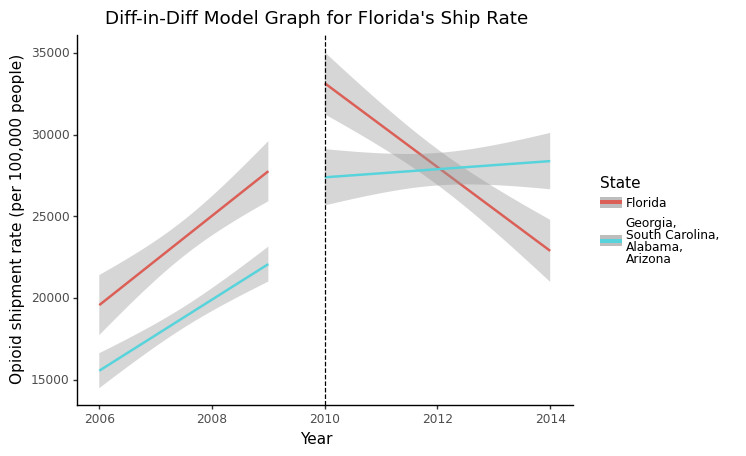

In [6]:
florida_shiprate = (
    ggplot(
        florida_df,
        aes(x="year", y="ship_rate", color="state"),
    )
    + geom_smooth(method="lm", data=florida_df[florida_df["year"] < 2010], level=0.9)
    + geom_smooth(method="lm", data=florida_df[florida_df["year"] >= 2010], level=0.9)
    # + scale_x_continuous(breaks=[2002, 2005, 2007, 2010, 2012, 2015])
    + geom_vline(xintercept=2010, linetype="dashed")
    + theme_classic()
    + geom_text(x=2010, y=10000, label="Policy Change", color="black")
    + labs(
        title="Diff-in-Diff Model Graph for Florida's Ship Rate",
        y="Opioid shipment rate (per 100,000 people)",
        x="Year",
        color="State",
    )
    + theme(legend_position="right")
    + xlim(2006, 2014)
    + scale_color_discrete(
        labels=["Florida", f"Georgia,\nSouth Carolina,\nAlabama,\nArizona"]
    )
)
print(florida_shiprate)


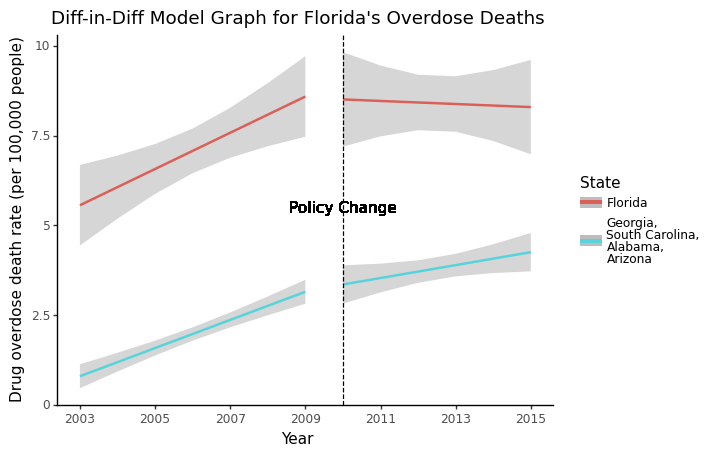

In [7]:
florida_deaths = (
    ggplot(
        florida_df,
        aes(x="year", y="death_rate", color="state"),
    )
    + geom_smooth(method="lm", data=florida_df[florida_df["year"] < 2010], level=0.9)
    + geom_smooth(method="lm", data=florida_df[florida_df["year"] >= 2010], level=0.9)
    + scale_x_continuous(breaks=[2003, 2005, 2007, 2009, 2011, 2013, 2015])
    + geom_vline(xintercept=2010, linetype="dashed")
    + geom_text(x=2010, y=5.5, label="Policy Change", color="black")
    + theme_classic()
    + labs(
        title="Diff-in-Diff Model Graph for Florida's Overdose Deaths",
        y="Drug overdose death rate (per 100,000 people)",
        x="Year",
        color="State",
    )
    + theme(legend_position="right")
    # + xlim(2003, 2015)
    + scale_color_discrete(
        labels=["Florida", f"Georgia,\nSouth Carolina,\nAlabama,\nArizona"]
    )
    # + scale_color_continuous(values=["#EA738DFF", "#89ABE3FF"])
)
print(florida_deaths)


## Texas

In [8]:
states_texas_for_df = states_texas + ["TX"]
texas_df = final_df.copy()
texas_df = texas_df.loc[texas_df["state"].isin(states_texas_for_df)]
texas_df[texas_df["state"] == "OK"]


,county_name,state,year,fips,merge_key,drug_deaths,drug_quantity,population,death_rate,ship_rate
7631,"ADAIR COUNTY, OK",OK,2003,40001,400012003,0.0,0.0,22683,0.0,0.000000
7632,"ADAIR COUNTY, OK",OK,2004,40001,400012004,0.0,0.0,22683,0.0,0.000000
7633,"ADAIR COUNTY, OK",OK,2005,40001,400012005,0.0,0.0,22683,0.0,0.000000
7634,"ADAIR COUNTY, OK",OK,2006,40001,400012006,0.0,2767.0,22683,0.0,12198.562800
7635,"ADAIR COUNTY, OK",OK,2007,40001,400012007,0.0,3389.0,22683,0.0,14940.704492
...,...,...,...,...,...,...,...,...,...,...
8627,"WOODWARD COUNTY, OK",OK,2011,40153,401532011,0.0,6438.0,20081,0.0,32060.156367
8628,"WOODWARD COUNTY, OK",OK,2012,40153,401532012,0.0,5917.0,20081,0.0,29465.664061
8629,"WOODWARD COUNTY, OK",OK,2013,40153,401532013,0.0,4749.0,20081,0.0,23649.220656
8630,"WOODWARD COUNTY, OK",OK,2014,40153,401532014,0.0,3982.0,20081,0.0,19829.689756


In [9]:
texas_df["state"] = texas_df["state"].replace(
    dict.fromkeys(states_texas, "zSimilar States")
) # added z infront to make sure it is at the end of the list
texas_df[texas_df["state"] == "TX"]


,county_name,state,year,fips,merge_key,drug_deaths,drug_quantity,population,death_rate,ship_rate
9698,"ANDERSON COUNTY, TX",TX,2003,48001,480012003,0.0,0.0,58458,0.000000,0.000000
9699,"ANDERSON COUNTY, TX",TX,2004,48001,480012004,11.0,0.0,58458,18.816928,0.000000
9700,"ANDERSON COUNTY, TX",TX,2005,48001,480012005,0.0,0.0,58458,0.000000,0.000000
9701,"ANDERSON COUNTY, TX",TX,2006,48001,480012006,10.0,12172.0,58458,17.106299,20821.786582
9702,"ANDERSON COUNTY, TX",TX,2007,48001,480012007,0.0,10912.0,58458,0.000000,18666.392966
...,...,...,...,...,...,...,...,...,...,...
12995,"ZAVALA COUNTY, TX",TX,2011,48507,485072011,0.0,652.0,11677,0.000000,5583.625931
12996,"ZAVALA COUNTY, TX",TX,2012,48507,485072012,0.0,829.0,11677,0.000000,7099.426222
12997,"ZAVALA COUNTY, TX",TX,2013,48507,485072013,0.0,639.0,11677,0.000000,5472.295966
12998,"ZAVALA COUNTY, TX",TX,2014,48507,485072014,0.0,476.0,11677,0.000000,4076.389484


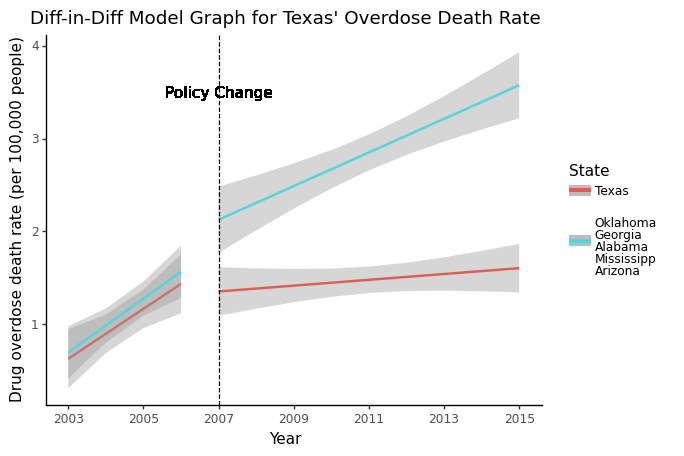

In [10]:
texas_deathrate = (
    ggplot(
        texas_df,
        aes(x="year", y="death_rate", color="state"),
    )
    + geom_smooth(method="lm", data=texas_df[texas_df["year"] < 2007], level=0.9)
    + geom_smooth(method="lm", data=texas_df[texas_df["year"] >= 2007], level=0.9)
    + scale_x_continuous(breaks=[2003, 2005, 2007, 2009, 2011, 2013, 2015])
    + geom_vline(xintercept=2007, linetype="dashed")
    + geom_text(x=2007, y=3.5, label="Policy Change", color="black")
    + theme_classic()
    + labs(
        title="Diff-in-Diff Model Graph for Texas' Overdose Death Rate",
        y="Drug overdose death rate (per 100,000 people)",
        x="Year",
        color="State",
    )
    + theme(legend_position="right")
    + scale_color_discrete(
        labels=["Texas", f"\nOklahoma\nGeorgia\nAlabama\nMississipp\nArizona"]
    )  # "OK", "GA", "AL", "MS", "AZ"
)
print(texas_deathrate)


## Washington

In [11]:
states_washington_for_df = states_washington + ["WA"]
washington_df = final_df.copy()
washington_df = washington_df.loc[washington_df["state"].isin(states_washington_for_df)]
washington_df[washington_df["state"] == "ID"]


,county_name,state,year,fips,merge_key,drug_deaths,drug_quantity,population,death_rate,ship_rate
4758,"ADA COUNTY, ID",ID,2003,16001,160012003,17.0,0.0,392365,4.332700,0.000000
4759,"ADA COUNTY, ID",ID,2004,16001,160012004,21.0,0.0,392365,5.352159,0.000000
4760,"ADA COUNTY, ID",ID,2005,16001,160012005,20.0,0.0,392365,5.097295,0.000000
4761,"ADA COUNTY, ID",ID,2006,16001,160012006,32.0,79124.0,392365,8.155671,20165.916940
4762,"ADA COUNTY, ID",ID,2007,16001,160012007,32.0,78505.0,392365,8.155671,20008.155671
...,...,...,...,...,...,...,...,...,...,...
5325,"WASHINGTON COUNTY, ID",ID,2011,16087,160872011,0.0,2041.0,10198,0.000000,20013.728182
5326,"WASHINGTON COUNTY, ID",ID,2012,16087,160872012,0.0,2375.0,10198,0.000000,23288.880173
5327,"WASHINGTON COUNTY, ID",ID,2013,16087,160872013,0.0,2415.0,10198,0.000000,23681.113944
5328,"WASHINGTON COUNTY, ID",ID,2014,16087,160872014,0.0,2525.0,10198,0.000000,24759.756815


In [12]:
washington_df["state"] = washington_df["state"].replace(
    dict.fromkeys(states_washington, "zSimilar States")
) # added z infront to make sure it is at the end of the list
washington_df[washington_df["state"] == "WA"]


,county_name,state,year,fips,merge_key,drug_deaths,drug_quantity,population,death_rate,ship_rate
13000,"ADAMS COUNTY, WA",WA,2003,53001,530012003,0.0,0.0,18728,0.000000,0.000000
13001,"ADAMS COUNTY, WA",WA,2004,53001,530012004,0.0,0.0,18728,0.000000,0.000000
13002,"ADAMS COUNTY, WA",WA,2005,53001,530012005,0.0,0.0,18728,0.000000,0.000000
13003,"ADAMS COUNTY, WA",WA,2006,53001,530012006,0.0,2321.0,18728,0.000000,12393.208031
13004,"ADAMS COUNTY, WA",WA,2007,53001,530012007,0.0,2571.0,18728,0.000000,13728.107646
...,...,...,...,...,...,...,...,...,...,...
13502,"YAKIMA COUNTY, WA",WA,2011,53077,530772011,14.0,58730.0,243231,5.755845,24145.770893
13503,"YAKIMA COUNTY, WA",WA,2012,53077,530772012,25.0,64284.0,243231,10.278295,26429.196936
13504,"YAKIMA COUNTY, WA",WA,2013,53077,530772013,14.0,63870.0,243231,5.755845,26258.988369
13505,"YAKIMA COUNTY, WA",WA,2014,53077,530772014,23.0,72444.0,243231,9.456032,29784.032463


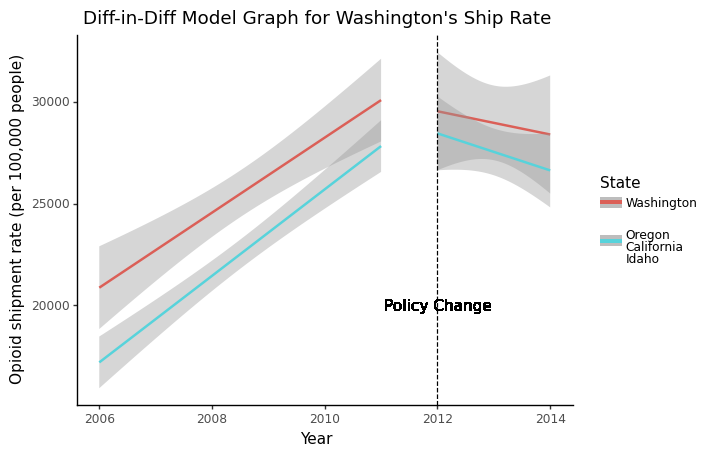

In [13]:
washington_shiprate = (
    ggplot(
        washington_df,
        aes(x="year", y="ship_rate", color="state"),
    )
    + geom_smooth(
        method="lm", data=washington_df[washington_df["year"] < 2012], level=0.9
    )
    + geom_smooth(
        method="lm", data=washington_df[washington_df["year"] >= 2012], level=0.9
    )
    # + scale_x_continuous(breaks=[2002, 2005, 2007, 2010, 2012, 2015])
    + geom_vline(xintercept=2012, linetype="dashed")
    + geom_text(x=2012, y=20000, label="Policy Change", color="black")
    + theme_classic()
    + labs(
        title="Diff-in-Diff Model Graph for Washington's Ship Rate",
        y="Opioid shipment rate (per 100,000 people)",
        x="Year",
        color="State",
    )
    + theme(legend_position="right")
    + xlim(2006, 2014)
    + scale_color_discrete(
        labels=["Washington", f"\nOregon\nCalifornia\nIdaho"]
    )  # "OR", "CA", "ID"
)
print(washington_shiprate)


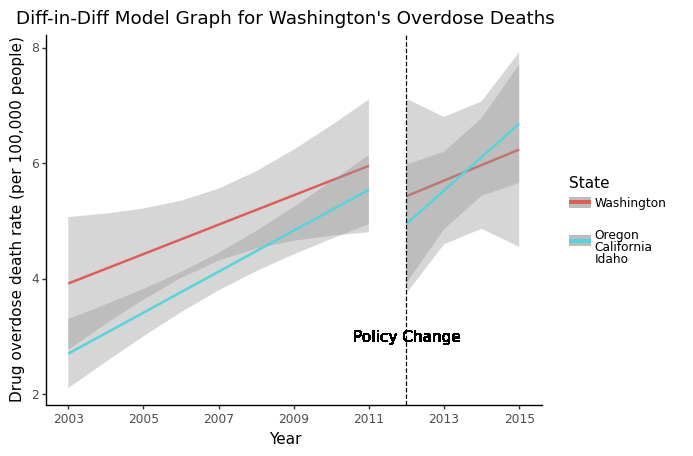

In [14]:
washington_deaths = (
    ggplot(
        washington_df,
        aes(x="year", y="death_rate", color="state"),
    )
    + geom_smooth(
        method="lm", data=washington_df[washington_df["year"] < 2012], level=0.9
    )
    + geom_smooth(
        method="lm", data=washington_df[washington_df["year"] >= 2012], level=0.9
    )
    + scale_x_continuous(breaks=[2003, 2005, 2007, 2009, 2011, 2013, 2015])
    + geom_vline(xintercept=2012, linetype="dashed")
    + geom_text(x=2012, y=3, label="Policy Change", color="black")
    + theme_classic()
    + labs(
        title="Diff-in-Diff Model Graph for Washington's Overdose Deaths",
        y="Drug overdose death rate (per 100,000 people)",
        x="Year",
        color="State",
    )
    + theme(legend_position="right")
    + scale_color_discrete(
        labels=["Washington", f"\nOregon\nCalifornia\nIdaho"]
    )  # "OR", "CA", "ID"
)
print(washington_deaths)
